<a href="https://colab.research.google.com/github/nirnayroy/2d-billiards/blob/master/Copy_of_2d_billiards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fermi Acceleration in 2d-billiards

# Imports

In [ ]:
!pip install shapely

In [39]:
#@title
import numpy as np
#from scipy import optimize
#from scipy.misc import derivative
import matplotlib.pyplot as plt
#import pickle 
from sklearn.preprocessing import normalize

#from shapely.geometry import LineString
#from shapely.geometry import Point

# Some functions

In [79]:
#slit position
def slit(t, s, omega):
    return -s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


# Travel for rectangle with slit

In [ ]:

#mapping function from one state to the next  
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


In [ ]:

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


In [ ]:

def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


In [ ]:

omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
    dbfile = open('ensemble2_100', 'ab') 
      
    # source, destination 
    pickle.dump(systems, dbfile)                      
    dbfile.close()
    return systems



In [ ]:

systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)


In [ ]:
import matplotlib.pyplot as plt
def load_and_plot(time_step=1):
    
    dbfile = open('ensemble2', 'rb')      
    systems = pickle.load(dbfile) 
    
    t = 1
    
    tfs = []
    for i in systems:
        last_state = i[len(i)-1]
        #print(last_state)
        (x, y, u, v, tm) = last_state
        tfs.append(tm)
    
    tf = min(tfs)
     
    #print(tf)
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<t2 and t>t1:
                    v += ((v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        #print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

[4333.7531107363575, 4620.855276032316, 5166.599944930533, 5699.88178690181, 6123.237379250558, 6342.2125597567365, 6350.904854983463, 6856.617443316063, 7486.465641915043, 8012.077270917688, 8486.73231278515, 8652.635143721285, 9491.019845687464, 9577.259902409387, 10287.677709275411, 10466.46170717086, 11347.304446746577, 12545.698230169282, 14024.503667592347, 14909.898383584286, 17242.622126118804, 18677.013810298922, 20508.175033088428, 23931.24883240195, 21108.74190138676, 21780.135594746956, 23576.32517277359, 23678.46022377276, 26002.784754953438, 27028.108758986356, 30821.53984096212, 30936.95811236209, 29092.146627217953, 31125.56130226421, 30880.65087704504, 31982.442207685974]
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501]


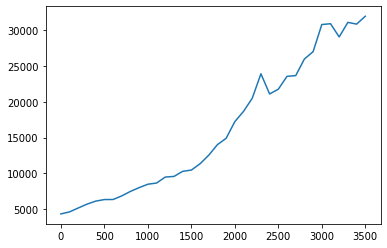

In [ ]:
load_and_plot(time_step=100)

In [ ]:
import pickle 
dbfile = open('ensemble2_100', 'rb')      
systems = pickle.load(dbfile) 

FileNotFoundError: [Errno 2] No such file or directory: 'ensemble2_100'

# Trapezium Billiards

In [40]:
def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))


def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    
    p = Point(0,h)
    c = p.buffer(l).boundary

    x_left = -l
    x_right = l
    m = (vel_vec[1]/vel_vec[0])
    k = 1
    while k>0:
        y_left = line2cord(m , x, h, x_left)
        y_right = line2cord(m , x, h, x_right)
        #print((x_left,y_left),(x_right, y_right))
        ls = LineString([Point(x_left,y_left), Point(x_right, y_right)])
        inte = c.intersection(ls)
       
        pois = [inte.geoms[0].coords[0], inte.geoms[1].coords[0]]
        print(pois)
        if (pois[0][1]>h) != (pois[1][1]>h):
            print('1yh')
            if pois[0][1]>h:
                x_ =  pois[0][0]
                y_ = pois[0][1]
            else:
                x_ =  pois[1][0]
                y_ = pois[1][1]
            if (x_ - x)/vel_vec[0]< 0:
                print('t dec: x_ , x, u:', x_, x, vel_vec[0] )
            t += (x_ - x)/vel_vec[0]
            x = x_
            y = y_
            if k>0:
                k = -2
                

        elif (pois[0][1]>h and pois[1][1]>h) and (k>0):
            print('2yh')
            #collision inside
            sol1 = pois[0][0]
            sol2 = pois[1][0]
            if x == sol1:
                t += (x - sol2)/vel_vec[0]
                x = sol2
                y = pois[1][1]
            elif x == sol2:
                t += (x - sol1)/vel_vec[0]
                x = sol1
                y = pois[0][1]
            else:
                print('no intersection')


        else:
            #error
            print('err3')

        p = float(d_sem_func(x, r))
        nor_vec = [-np.sign(p), -np.sign(p)*(1/p)]
        nor_vec = normalize(nor_vec)
        #nor_inc = normalize(vel_vec)
        ref = vel_vec - (2*np.dot(nor_inc, vel_vec)*nor_vec)
        ref = np.linalg.norm(vel_vec)*normalize(ref)
        
        if np.linalg.norm(ref) != np.linalg.norm(vel_vec):
            print('unnormalized collision')
        if k== -2:
            if ref[1]>0:
                print('other way')
            del_t = ((h-y)/ref[1])
            if del_t < 0:
                print('t dec_2: y:', y, 'h:', h, 'v:', ref[1])
            print('v')
            t += del_t
            x += ref[0]*del_t
            y = h
            if abs(x) > l:
                print('x:', x, 'x_:', x_)
            return (x, y, ref[0], ref[1], t)
        k += 1
        m = ref[1]/ref[0]

#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    print('t_left:',time_step[0], 't_right:',time_step[1], 
           't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            yf = -h
            vf = -v
            uf = u
            xf = x + u*time_step[di]
            #print('next wall: bottom')
    
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10)
plot_bill(res)


    


t_left: -8.09629893137039 t_right: 16.81539008823081 t_top: 0.25063589562403643 t_bottom: -0.05316518998085621
next wall: semi-circle enclosure


NameError: name 'Point' is not defined

In [ ]:
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


# Stadium Billiards

In [43]:
k = d_sem_func(x = 1, r = 2)
nor_vec = [-np.sign(k), -np.sign(k)*(1/k)]
nor_vec = normalize(nor_vec)
nor_vec 

array([-0.5      , -0.8660254])

In [21]:
x = -23
np.sign(x)

-1

next wall: semi-circle enclosure
entered enclosure: x: -0.6597560975609755 y: 1 u: 0.16056719385235946 v: 6.583254947946738
exit enclosure: x: [0.82709656] y: 1 u: [3.97350519] v: [-5.2513126]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.07170992] y: 1 u: [-3.97350519] v: [5.25340595]
exit enclosure: x: [-0.06884557] y: 1 u: [3.66667314] v: [-5.47197639]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.32449026] y: 1 u: [-3.66667314] v: [5.47621401]
exit enclosure: x: [-1.31180574] y: 1 u: [-3.58632568] v: [-5.5291663]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.03480026] y: 1 u: [3.58632568] v: [5.53563658]
exit enclosure: x: [0.03416838] y: 1 u: [-3.42313639] v: [-5.63800865]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.553795] y: 1 u: [3.42313639] v: [5.64641495]
exit enclosure: x: [1.86921998] y: 1 u: [-4.64434942] v: [-4.6

exit enclosure: x: [0.55662021] y: 1 u: [4.79184878] v: [-4.34370244]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.05169739] y: 1 u: [-4.79184878] v: [4.35450997]
exit enclosure: x: [1.08729711] y: 1 u: [-4.91763761] v: [-4.21193686]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.34414729] y: 1 u: [4.91763761] v: [4.22495405]
exit enclosure: x: [0.27883261] y: 1 u: [-3.85241761] v: [-5.21462127]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.28463978] y: 1 u: [3.85241761] v: [5.22916083]
exit enclosure: x: [1.14975795] y: 1 u: [2.83710164] v: [-5.84261061]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88740604] y: 1 u: [-2.83710164] v: [5.85838875]
exit enclosure: x: [-0.85684968] y: 1 u: [-2.35746843] v: [-6.06730641]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.57680674] y: 1 u: [2.3574

exit enclosure: x: [-1.04278127] y: 1 u: [-2.86699059] v: [-6.05105609]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.09682424] y: 1 u: [2.86699059] v: [6.03962376]
exit enclosure: x: [1.19521583] y: 1 u: [3.73873074] v: [-5.54243472]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.1497414] y: 1 u: [-3.73873074] v: [5.52937723]
exit enclosure: x: [-0.13916233] y: 1 u: [3.0253875] v: [-5.94971853]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.86685511] y: 1 u: [3.0253875] v: [5.93531415]
exit enclosure: x: [-1.66862821] y: 1 u: [-0.53470483] v: [-6.6404077]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.98721989] y: 1 u: [-0.53470483] v: [6.62466901]
exit enclosure: x: [1.99237871] y: 1 u: [-0.71615798] v: [-6.60751591]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.56214134] y: 1 u: [-0.71615798] v: [6.59073235]
exit enclosure: x: [-1.6289347

next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.80746432] y: 1 u: [6.4968953] v: [0.38721411]
exit enclosure: x: [-1.31432592] y: 1 u: [6.5040751] v: [-0.2378874]
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
bottom bar
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: right
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.59525899] y: 1 u: [6.5040751] v: [0.25327458]
exit enclosure: x: [0.37332015] y: 1 u: [-6.49646435] v: [-0.40384633]
next wall: left
next wall: right
next wall: left
next wall: right
next wall: le

exit enclosure: x: [-1.45833238] y: 1 u: [3.59836327] v: [-5.39825438]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.16415149] y: 1 u: [3.59836327] v: [5.41252871]
exit enclosure: x: [-1.12404141] y: 1 u: [3.28940236] v: [-5.60566833]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.17867686] y: 1 u: [3.28940236] v: [5.6182207]
exit enclosure: x: [-1.14542289] y: 1 u: [2.99346039] v: [-5.78132914]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.88210064] y: 1 u: [2.99346039] v: [5.79193317]
exit enclosure: x: [-1.58642583] y: 1 u: [5.66883952] v: [-3.22048964]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-1.28911017] y: 1 u: [-5.66883952] v: [3.2286141]
exit enclosure: x: [0.90629359] y: 1 u: [-4.63355048] v: [-4.59237417]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.96916385] y: 1 u: [4.63355048] v: [4.59758118]
exit enclosure: x: [0.68556829]

exit enclosure: x: [-1.00554515] y: 1 u: [3.0857585] v: [-5.37506835]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.32811059] y: 1 u: [3.0857585] v: [5.36063164]
exit enclosure: x: [-1.16714228] y: 1 u: [1.02414109] v: [-6.09995181]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.48301052] y: 1 u: [1.02414109] v: [6.08721449]
exit enclosure: x: [0.50084395] y: 1 u: [1.90804756] v: [-5.87046844]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.82772891] y: 1 u: [1.90804756] v: [5.85933912]
exit enclosure: x: [-1.85014487] y: 1 u: [-2.11365098] v: [-5.78834864]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.65635553] y: 1 u: [2.11365098] v: [5.77943841]
exit enclosure: x: [0.64067592] y: 1 u: [1.67707743] v: [-5.9208817]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.80048869] y: 1 u: [1.67707743] v: [5.9139471]
exit enclosure: x: [-1.80090407] y: 1 u: [-1.6818801

exit enclosure: x: [-0.11894266] y: 1 u: [-2.34643253] v: [-5.9809341]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.65403521] y: 1 u: [-2.34643253] v: [5.99067035]
exit enclosure: x: [1.91484772] y: 1 u: [-3.82312227] v: [-5.17470898]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.9711018] y: 1 u: [-3.82312227] v: [5.18213343]
exit enclosure: x: [1.25761232] y: 1 u: [-5.04564093] v: [-4.0015345]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.33837827] y: 1 u: [5.04564093] v: [4.00626369]
exit enclosure: x: [0.2725791] y: 1 u: [-4.09565428] v: [-4.97335472]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.06089754] y: 1 u: [4.09565428] v: [4.97565709]
exit enclosure: x: [0.82906418] y: 1 u: [0.99633996] v: [-6.36701297]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.43935281] y: 1 u: [0.99633996] v: [6.36704796]
exit enclosure: x: [-1.44473209

exit enclosure: x: [1.11871661] y: 1 u: [-4.72345175] v: [-4.04069054]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.35318887] y: 1 u: [4.72345175] v: [4.05097345]
exit enclosure: x: [0.28485602] y: 1 u: [-3.67334051] v: [-5.02274345]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.30956833] y: 1 u: [3.67334051] v: [5.03495684]
exit enclosure: x: [1.19552099] y: 1 u: [2.90276204] v: [-5.51526912]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.66858631] y: 1 u: [-2.90276204] v: [5.52915299]
exit enclosure: x: [-0.59607892] y: 1 u: [-0.73225646] v: [-6.2017224]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.07410251] y: 1 u: [-0.73225646] v: [6.21688368]
exit enclosure: x: [1.49175935] y: 1 u: [-4.37590363] v: [-4.47630535]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.5492841] y: 1 u: [4.37590363] v: [4.492727

exit enclosure: x: [-1.3953283] y: 1 u: [-0.45657193] v: [-6.31318633]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.68598622] y: 1 u: [-0.45657193] v: [6.2953949]
exit enclosure: x: [1.72248653] y: 1 u: [-1.36759035] v: [-6.16199249]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82739354] y: 1 u: [-1.36759035] v: [6.14472501]
exit enclosure: x: [-0.98698178] y: 1 u: [-3.61848726] v: [-5.15116479]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.17094592] y: 1 u: [3.61848726] v: [5.13465953]
exit enclosure: x: [0.15705162] y: 1 u: [-2.8674279] v: [-5.58892081]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.9239814] y: 1 u: [-2.8674279] v: [5.57342104]
exit enclosure: x: [1.82133794] y: 1 u: [2.14995492] v: [-5.8875172]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.69330376] y: 1 u: [-2.14995492] v: [5.87352463]
exit enclosure: x: [-0.6841392

exit enclosure: x: [-1.17131998] y: 1 u: [1.29669215] v: [-6.14797817]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.34073183] y: 1 u: [1.29669215] v: [6.16268914]
exit enclosure: x: [0.33616427] y: 1 u: [0.80146203] v: [-6.2464235]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.84034438] y: 1 u: [0.80146203] v: [6.25984983]
exit enclosure: x: [-1.51251109] y: 1 u: [-5.26611462] v: [-3.47794451]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.55658295] y: 1 u: [-5.26611462] v: [3.48947483]
exit enclosure: x: [-0.39440556] y: 1 u: [3.95719548] v: [-4.92432755]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.2514394] y: 1 u: [-3.95719548] v: [4.93370947]
exit enclosure: x: [-1.03691733] y: 1 u: [-2.13208822] v: [-5.95441727]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.56437398] y: 1 u: [2.13208822] v: [5.961697

next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-0.13304329] y: 1 u: [-5.27386103] v: [3.29028731]
exit enclosure: x: [0.1503801] y: 1 u: [5.49234975] v: [-2.91096119]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.21487903] y: 1 u: [5.49234975] v: [2.9257337]
exit enclosure: x: [0.18143901] y: 1 u: [-5.16912751] v: [-3.46495948]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.8343036] y: 1 u: [5.16912751] v: [3.48124995]
exit enclosure: x: [-1.02471603] y: 1 u: [0.07447718] v: [-6.23164774]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.97665028] y: 1 u: [0.07447718] v: [6.24891497]
exit enclosure: x: [1.83132598] y: 1 u: [5.28663655] v: [-3.33256044]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.17908988] y: 1 u: [5.28663655] v: [3.35037897]
exit enclosure: x: [-0.21211433] y: 1 u: [-5.5831

exit enclosure: x: [1.99778742] y: 1 u: [-2.96076876] v: [-5.19557199]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.33868995] y: 1 u: [-2.96076876] v: [5.19314332]
exit enclosure: x: [0.42829293] y: 1 u: [4.34396164] v: [-4.10668801]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.76513421] y: 1 u: [-4.34396164] v: [4.10677086]
exit enclosure: x: [1.74247696] y: 1 u: [-5.69944145] v: [-1.80331272]
next wall: left
bottom bar
next wall: right
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.80802522] y: 1 u: [5.69944145] v: [1.80746024]
exit enclosure: x: [0.46582136] y: 1 u: [-5.09123345] v: [-3.13526511]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.8328248] y: 1 u: [-5.09123345] v: [3.14311655]
exit enclosure: x: [-0.96289451] y: 1 u: [0.07895411] v: [-5.98277577]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.90907586

entered enclosure: x: [1.72083613] y: 1 u: [6.05433484] v: [1.07801167]
exit enclosure: x: [-0.72454232] y: 1 u: [5.59121551] v: [-2.56034931]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.22846506] y: 1 u: [5.59121551] v: [2.55494475]
exit enclosure: x: [-0.28995663] y: 1 u: [-5.80833949] v: [-2.01311351]
next wall: left
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.12306539] y: 1 u: [5.80833949] v: [2.01157232]
exit enclosure: x: [-0.13938395] y: 1 u: [-5.88462613] v: [-1.7760648]
next wall: left
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [1.708045] y: 1 u: [5.88462613] v: [1.7789879]
exit enclosure: x: [-0.76244166] y: 1 u: [4.68088297] v: [-3.9853428]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-0.04022718] y: 1 u: [-4.68088297] v: [3.99212552]
exit enclosure: x: [0.04151179] y

entered enclosure: x: [1.65963043] y: 1 u: [-3.04164624] v: [5.38073096]
exit enclosure: x: [-1.58737093] y: 1 u: [2.5604132] v: [-5.6256699]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.20714168] y: 1 u: [2.5604132] v: [5.61158616]
exit enclosure: x: [-0.2310199] y: 1 u: [-3.56775748] v: [-5.03157247]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.96505669] y: 1 u: [3.56775748] v: [5.01619792]
exit enclosure: x: [0.80084133] y: 1 u: [1.16261943] v: [-6.0447871]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.56349258] y: 1 u: [1.16261943] v: [6.02834225]
exit enclosure: x: [-1.79998709] y: 1 u: [-3.20527376] v: [-5.23629777]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.23652404] y: 1 u: [3.20527376] v: [5.21896824]
exit enclosure: x: [-0.2761399] y: 1 u: [-4.1866895] v: [-4.47023942]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x

entered enclosure: x: [-1.09516292] y: 1 u: [0.08398215] v: [6.12385718]
exit enclosure: x: [1.63637671] y: 1 u: [-4.55096925] v: [-4.09845808]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.29704175] y: 1 u: [4.55096925] v: [4.0927414]
exit enclosure: x: [0.86880633] y: 1 u: [0.35923913] v: [-6.11005733]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.0988807] y: 1 u: [0.35923913] v: [6.10199373]
exit enclosure: x: [-1.51422021] y: 1 u: [4.21353534] v: [-4.42826153]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.78146975] y: 1 u: [-4.21353534] v: [4.41786862]
exit enclosure: x: [-1.60627444] y: 1 u: [-3.64199953] v: [-4.89972271]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.52992585] y: 1 u: [3.64199953] v: [4.88719794]
exit enclosure: x: [-0.88276746] y: 1 u: [-5.34244818] v: [-2.93378795]
next wall: left
bottom bar
next wall: right
next wall: sem

exit enclosure: x: [-0.6290597] y: 1 u: [-0.51580984] v: [-6.04595286]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.96904376] y: 1 u: [-0.51580984] v: [6.06383065]
exit enclosure: x: [1.91206217] y: 1 u: [-5.25277519] v: [-3.07318315]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.8625888] y: 1 u: [5.25277519] v: [3.09054948]
exit enclosure: x: [-1.27513136] y: 1 u: [5.72470614] v: [-2.09066567]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [1.50972757] y: 1 u: [5.72470614] v: [2.10654563]
exit enclosure: x: [-0.80707987] y: 1 u: [4.65640846] v: [-3.94051457]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.16446718] y: 1 u: [-4.65640846] v: [3.95424212]
exit enclosure: x: [-0.14690883] y: 1 u: [4.2096539] v: [-4.42684815]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.41921358] y: 1 u: [-4.209653

exit enclosure: x: [-0.62225615] y: 1 u: [-1.28271153] v: [-5.93273631]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.49365441] y: 1 u: [-1.28271153] v: [5.91532657]
exit enclosure: x: [1.55081755] y: 1 u: [2.04385695] v: [-5.69728761]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.99835185] y: 1 u: [-2.04385695] v: [5.68070192]
exit enclosure: x: [-1.16473802] y: 1 u: [-3.56912351] v: [-4.86919736]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.1385448] y: 1 u: [3.56912351] v: [4.85370127]
exit enclosure: x: [-0.15194268] y: 1 u: [-4.08779888] v: [-4.42571564]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.20335245] y: 1 u: [4.08779888] v: [4.41161018]
exit enclosure: x: [0.18048438] y: 1 u: [-3.38611221] v: [-4.97057825]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.40296296] y: 1 u: [3.38611221] v: [4.9581

exit enclosure: x: [-1.31233774] y: 1 u: [-0.70663027] v: [-5.93972426]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.79445636] y: 1 u: [-0.70663027] v: [5.92388563]
exit enclosure: x: [1.96175233] y: 1 u: [2.49587649] v: [-5.41870352]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.16562206] y: 1 u: [-2.49587649] v: [5.40435793]
exit enclosure: x: [-0.15655144] y: 1 u: [1.65735412] v: [-5.71748734]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.02448584] y: 1 u: [1.65735412] v: [5.7046023]
exit enclosure: x: [-1.41463127] y: 1 u: [4.26867248] v: [-4.13131279]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.19313791] y: 1 u: [-4.26867248] v: [4.12060019]
exit enclosure: x: [-0.82975002] y: 1 u: [-0.304598] v: [-5.92521145]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.04005192] y: 1 u: [-0.304598] v: [5.91664788]
exit enclosure: x: [1.6833865

exit enclosure: x: [1.43220897] y: 1 u: [4.42082403] v: [-4.34014791]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.4139046] y: 1 u: [-4.42082403] v: [4.33388678]
exit enclosure: x: [1.0285572] y: 1 u: [-1.68333258] v: [-5.95757091]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.07780149] y: 1 u: [-1.68333258] v: [5.94879878]
exit enclosure: x: [0.07971228] y: 1 u: [2.12364263] v: [-5.80619992]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.51445235] y: 1 u: [2.12364263] v: [5.79562622]
exit enclosure: x: [-1.52717531] y: 1 u: [-2.25104292] v: [-5.74734261]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.93249953] y: 1 u: [2.25104292] v: [5.73478784]
exit enclosure: x: [1.00244534] y: 1 u: [3.08165237] v: [-5.33464193]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.71962672] y: 1 u: [-3.08165237] v: [5.32053185]
exit enclosur

exit enclosure: x: [1.36074429] y: 1 u: [5.4090368] v: [-3.00877012]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.47326772] y: 1 u: [5.4090368] v: [3.02573925]
exit enclosure: x: [-0.84056239] y: 1 u: [-5.95906985] v: [-1.70360314]
next wall: left
next wall: right
bottom bar
next wall: left
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.41345581] y: 1 u: [-5.95906985] v: [1.71882653]
exit enclosure: x: [-0.62679273] y: 1 u: [4.84159557] v: [-3.87605863]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-0.27387352] y: 1 u: [-4.84159557] v: [3.88882284]
exit enclosure: x: [0.35450354] y: 1 u: [5.43488664] v: [-3.00432987]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.56806147] y: 1 u: [5.43488664] v: [3.01486001]
exit enclosure: x: [0.3906763] y: 1 u: [-4.40569415] v: [-4.38374642]
bottom bar
next wall: left
next 

entered enclosure: x: [-1.24850255] y: 1 u: [2.49683342] v: [5.46456325]
exit enclosure: x: [1.59585101] y: 1 u: [4.22121085] v: [-4.27516171]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.61451099] y: 1 u: [-4.22121085] v: [4.28689146]
exit enclosure: x: [1.15482916] y: 1 u: [0.52579287] v: [-5.99329636]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.51102471] y: 1 u: [0.52579287] v: [6.00696548]
exit enclosure: x: [-1.60473585] y: 1 u: [-2.0899117] v: [-5.65617906]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.89973515] y: 1 u: [2.0899117] v: [5.6713979]
exit enclosure: x: [0.97199602] y: 1 u: [2.99539553] v: [-5.24977053]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.72564389] y: 1 u: [-2.99539553] v: [5.26610527]
exit enclosure: x: [-0.63566923] y: 1 u: [-0.75252003] v: [-6.01148673]
bottom bar
next wall: semi-circle enclosure
entered enclos

exit enclosure: x: [0.43647789] y: 1 u: [4.77464604] v: [-3.75305366]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.62289586] y: 1 u: [-4.77464604] v: [3.76323638]
exit enclosure: x: [1.01358227] y: 1 u: [-0.80779539] v: [-6.02550076]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.46819331] y: 1 u: [-0.80779539] v: [6.03788204]
exit enclosure: x: [-0.49143017] y: 1 u: [-2.00464711] v: [-5.75238584]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.90579548] y: 1 u: [-2.00464711] v: [5.76625113]
exit enclosure: x: [1.81566843] y: 1 u: [-0.79734428] v: [-6.05247918]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.28265216] y: 1 u: [-0.79734428] v: [6.0678964]
exit enclosure: x: [-1.46188379] y: 1 u: [3.0183854] v: [-5.32395287]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82397668] y: 1 u: [3.0183854] v: [5.34054145]
exit enclosure: x: [-1.7955148] y: 1 u: [5.62

next wall: semi-circle enclosure
entered enclosure: x: [1.46264067] y: 1 u: [-4.45701879] v: [4.24968272]
exit enclosure: x: [-1.04138847] y: 1 u: [-1.51630186] v: [-5.96872251]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.95681578] y: 1 u: [1.51630186] v: [5.95452316]
exit enclosure: x: [1.98790634] y: 1 u: [1.84379024] v: [-5.86139531]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.76747098] y: 1 u: [-1.84379024] v: [5.84570519]
exit enclosure: x: [-0.8104376] y: 1 u: [-2.63190148] v: [-5.53578596]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.30269368] y: 1 u: [2.63190148] v: [5.51912223]
exit enclosure: x: [1.70894698] y: 1 u: [4.43709953] v: [-4.20710867]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.91207208] y: 1 u: [-4.43709953] v: [4.18963725]
exit enclosure: x: [1.52721045] y: 1 u: [3.11869971] v: [-5.24543846]
next w

next wall: semi-circle enclosure
entered enclosure: x: [-1.54303536] y: 1 u: [-1.80671956] v: [5.76949037]
exit enclosure: x: [1.65329476] y: 1 u: [2.74882816] v: [-5.38471898]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.27754157] y: 1 u: [-2.74882816] v: [5.39923321]
exit enclosure: x: [-0.25360916] y: 1 u: [1.33959583] v: [-5.90874424]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.66300417] y: 1 u: [1.33959583] v: [5.92444696]
exit enclosure: x: [-1.01604342] y: 1 u: [-4.68490385] v: [-3.86591058]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.89590322] y: 1 u: [4.68490385] v: [3.88268773]
exit enclosure: x: [-1.28131062] y: 1 u: [-2.0044773] v: [-5.74505517]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.31800958] y: 1 u: [2.0044773] v: [5.7626197]
exit enclosure: x: [1.76684895] y: 1 u: [-4.32974895] v: [-4.29871946]
bottom bar
next wall: lef

exit enclosure: x: [-0.34842808] y: 1 u: [-5.91804378] v: [-2.038639]
next wall: left
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.07145334] y: 1 u: [5.91804378] v: [2.02947644]
exit enclosure: x: [0.06694674] y: 1 u: [-5.86941704] v: [-2.16609334]
next wall: left
bottom bar
next wall: right
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.39349785] y: 1 u: [5.86941704] v: [2.15365803]
exit enclosure: x: [0.64670587] y: 1 u: [-4.18962072] v: [-4.64062254]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.08185009] y: 1 u: [4.18962072] v: [4.62594276]
exit enclosure: x: [0.8050597] y: 1 u: [0.5555051] v: [-6.21640429]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.1588177] y: 1 u: [0.5555051] v: [6.20048962]
exit enclosure: x: [-1.39047631] y: 1 u: [3.47159431] v: [-5.1674646]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.27

exit enclosure: x: [1.05966265] y: 1 u: [-5.20451432] v: [-3.42876758]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.8595956] y: 1 u: [5.20451432] v: [3.429603]
exit enclosure: x: [-1.30005698] y: 1 u: [5.80576596] v: [-2.26764804]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.69499617] y: 1 u: [5.80576596] v: [2.26464923]
exit enclosure: x: [-1.8826119] y: 1 u: [6.17548428] v: [-0.83603134]
next wall: right
next wall: left
next wall: right
bottom bar
next wall: left
next wall: right
next wall: left
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.81516476] y: 1 u: [-6.17548428] v: [0.8268848]
exit enclosure: x: [-0.4526381] y: 1 u: [6.05002216] v: [-1.48915294]
next wall: right
next wall: left
bottom bar
next wall: right
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.36350998] y: 1 u: [6.05002216] v: [1.47464728]
exit enclosure: x: [0.269

exit enclosure: x: [-0.25845784] y: 1 u: [-1.84589348] v: [-5.83581329]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.55516364] y: 1 u: [-1.84589348] v: [5.832614]
exit enclosure: x: [1.69432861] y: 1 u: [2.96078276] v: [-5.35354782]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.03807032] y: 1 u: [-2.96078276] v: [5.35299541]
exit enclosure: x: [-0.037402] y: 1 u: [2.78083478] v: [-5.44864684]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.94543803] y: 1 u: [-2.78083478] v: [5.45033858]
exit enclosure: x: [-1.94032355] y: 1 u: [2.75249543] v: [-5.46470508]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.12239437] y: 1 u: [2.75249543] v: [5.46911461]
exit enclosure: x: [-0.13033395] y: 1 u: [-3.33308436] v: [-5.13595117]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.21512425] y: 1 u: [3.33308436] v: [5.14252259]
exit enclosur

entered enclosure: x: [0.5958736] y: 1 u: [3.51056588] v: [5.26276204]
exit enclosure: x: [-1.07019578] y: 1 u: [-5.60663654] v: [-2.93024978]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-0.58553416] y: 1 u: [-5.60663654] v: [2.91932978]
exit enclosure: x: [1.30450051] y: 1 u: [6.18383476] v: [-1.31036155]
next wall: right
next wall: left
next wall: right
bottom bar
next wall: left
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.00486484] y: 1 u: [-6.18383476] v: [1.29610408]
exit enclosure: x: [-0.00484179] y: 1 u: [6.18253821] v: [-1.30227469]
next wall: right
next wall: left
bottom bar
next wall: right
next wall: left
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.03926354] y: 1 u: [-6.18253821] v: [1.2852223]
exit enclosure: x: [-0.52239155] y: 1 u: [5.77390826] v: [-2.55686498]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure:

entered enclosure: x: [1.72775493] y: 1 u: [1.2276477] v: [6.32884453]
exit enclosure: x: [-1.69640201] y: 1 u: [0.11344589] v: [-6.4458143]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.62774337] y: 1 u: [0.11344589] v: [6.44953509]
exit enclosure: x: [1.96837321] y: 1 u: [-3.62820312] v: [-5.33343369]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.68456156] y: 1 u: [-3.62820312] v: [5.33460969]
exit enclosure: x: [1.45480887] y: 1 u: [5.94312952] v: [-2.51020516]
next wall: right
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.21563198] y: 1 u: [-5.94312952] v: [2.50833435]
exit enclosure: x: [-0.61503645] y: 1 u: [4.12710689] v: [-4.95777354]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.36369707] y: 1 u: [-4.12710689] v: [4.95284372]
exit enclosure: x: [-1.14131445] y: 1 u: [-2.55777186] v: [-5.9178945]
next wall: left
bottom bar
next wall: se

exit enclosure: x: [1.0658205] y: 1 u: [-6.11715608] v: [-2.28470159]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-1.45619656] y: 1 u: [-6.11715608] v: [2.27377688]
exit enclosure: x: [0.81696932] y: 1 u: [-5.11507069] v: [-4.05286462]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.15705699] y: 1 u: [5.11507069] v: [4.03928327]
exit enclosure: x: [-0.18008021] y: 1 u: [-5.4835393] v: [-3.52286166]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.6634943] y: 1 u: [-5.4835393] v: [3.50766981]
exit enclosure: x: [-0.89873052] y: 1 u: [0.46975733] v: [-6.49247864]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.61186852] y: 1 u: [0.46975733] v: [6.47604707]
exit enclosure: x: [0.71484615] y: 1 u: [3.3813462] v: [-5.54313588]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.85918273] y: 1

next wall: semi-circle enclosure
entered enclosure: x: [-0.32250991] y: 1 u: [-2.80049895] v: [5.87601641]
exit enclosure: x: [0.39314009] y: 1 u: [4.37430824] v: [-4.82035171]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.06404398] y: 1 u: [-4.37430824] v: [4.8163643]
exit enclosure: x: [-0.06146715] y: 1 u: [4.14111599] v: [-5.0182762]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.83614504] y: 1 u: [-4.14111599] v: [5.01208025]
exit enclosure: x: [-0.64496917] y: 1 u: [0.22245406] v: [-6.49771531]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.51098696] y: 1 u: [0.22245406] v: [6.48949545]
exit enclosure: x: [0.57639319] y: 1 u: [3.01079395] v: [-5.75309975]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.37195378] y: 1 u: [-3.01079395] v: [5.74308503]
exit enclosure: x: [-1.78702288] y: 1 u: [-4.75471614] v: [-4.40914735]
next wall: left
bottom

exit enclosure: x: [0.75145836] y: 1 u: [1.71518554] v: [-6.05807179]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.90665037] y: 1 u: [1.71518554] v: [6.06793624]
exit enclosure: x: [-1.85349199] y: 1 u: [-0.89419211] v: [-6.24196541]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.5633513] y: 1 u: [0.89419211] v: [6.25389611]
exit enclosure: x: [1.59962096] y: 1 u: [1.59783616] v: [-6.11209585]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.33895475] y: 1 u: [-1.59783616] v: [6.12576819]
exit enclosure: x: [-1.54684527] y: 1 u: [3.45857648] v: [-5.30248669]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.09314728] y: 1 u: [3.45857648] v: [5.31767102]
exit enclosure: x: [-1.16098867] y: 1 u: [3.89486253] v: [-5.00693741]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.97647528] y: 1 u: [3.89486253] v: [5.02339328]
exit enclosure: x: [-1.6105349] 

exit enclosure: x: [-1.62244198] y: 1 u: [-1.67761723] v: [-6.11299049]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.25339645] y: 1 u: [1.67761723] v: [6.10697373]
exit enclosure: x: [1.76046054] y: 1 u: [-4.60483858] v: [-4.34798683]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.41846972] y: 1 u: [4.60483858] v: [4.34453396]
exit enclosure: x: [0.99366122] y: 1 u: [1.27118869] v: [-6.20190237]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.83406583] y: 1 u: [1.27118869] v: [6.20088216]
exit enclosure: x: [-1.87757955] y: 1 u: [1.83779848] v: [-6.05717401]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.63388988] y: 1 u: [1.83779848] v: [6.05876019]
exit enclosure: x: [0.63942011] y: 1 u: [2.00243081] v: [-6.00635906]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.99484627] y: 1 u: [-2.00243081] v: [6.01005723]
exit enclosur

next wall: semi-circle enclosure
entered enclosure: x: [-0.45786903] y: 1 u: [5.77377095] v: [2.5672511]
exit enclosure: x: [0.32722252] y: 1 u: [-5.19836092] v: [-3.59224901]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.50810247] y: 1 u: [5.19836092] v: [3.57475809]
exit enclosure: x: [-0.93067842] y: 1 u: [2.49939369] v: [-5.79265767]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.81409346] y: 1 u: [2.49939369] v: [5.77604242]
exit enclosure: x: [-1.93374758] y: 1 u: [-5.8048781] v: [-2.43167125]
next wall: left
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.3582722] y: 1 u: [5.8048781] v: [2.41654189]
exit enclosure: x: [0.27131719] y: 1 u: [-5.4179007] v: [-3.19102436]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.34884553] y: 1 u: [-5.4179007] v: [3.17797792]
exit enclosure: x: [-0.72488871] y: 1 u: [2.1175853

exit enclosure: x: [-0.92814958] y: 1 u: [3.81933472] v: [-5.13248664]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.88655773] y: 1 u: [-3.81933472] v: [5.12255527]
exit enclosure: x: [-1.61135065] y: 1 u: [2.20419463] v: [-5.99745081]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.10702763] y: 1 u: [2.20419463] v: [5.98980789]
exit enclosure: x: [0.10372192] y: 1 u: [-1.59220286] v: [-6.18070891]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.95162912] y: 1 u: [-1.59220286] v: [6.17498679]
exit enclosure: x: [1.63944707] y: 1 u: [-5.2743006] v: [-3.58431653]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.39420788] y: 1 u: [5.2743006] v: [3.58133874]
exit enclosure: x: [-0.60521129] y: 1 u: [-5.93317998] v: [-2.33272573]
next wall: left
bottom bar
next wall: right
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.96755322] y: 1 u: [5.93317

exit enclosure: x: [-1.66927735] y: 1 u: [-1.80932563] v: [-6.3368073]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.21504806] y: 1 u: [1.80932563] v: [6.33086282]
exit enclosure: x: [1.94042218] y: 1 u: [-5.25721132] v: [-3.96424172]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.74793387] y: 1 u: [5.25721132] v: [3.9559133]
exit enclosure: x: [0.50494614] y: 1 u: [-2.99217182] v: [-5.85955875]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.4977486] y: 1 u: [-2.99217182] v: [5.84916618]
exit enclosure: x: [1.37631807] y: 1 u: [1.62778666] v: [-6.36522959]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.61845907] y: 1 u: [-1.62778666] v: [6.35294947]
exit enclosure: x: [-1.60347822] y: 1 u: [-1.37550817] v: [-6.4123033]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.55111283] y: 1 u: [1.37550817] v: [6.3983783

entered enclosure: x: [-1.99523799] y: 1 u: [6.10982564] v: [1.86085649]
exit enclosure: x: [0.75085069] y: 1 u: [-4.04241451] v: [-4.94486007]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.43091598] y: 1 u: [4.04241451] v: [4.92984757]
exit enclosure: x: [1.25118776] y: 1 u: [2.97614828] v: [-5.63800085]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.60002445] y: 1 u: [-2.97614828] v: [5.62446416]
exit enclosure: x: [-0.53101907] y: 1 u: [-0.31857144] v: [-6.35535742]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.73543972] y: 1 u: [-0.31857144] v: [6.343315]
exit enclosure: x: [1.05676663] y: 1 u: [4.56629783] v: [-4.41452795]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.28446391] y: 1 u: [-4.56629783] v: [4.40434835]
exit enclosure: x: [1.01042625] y: 1 u: [-2.98365926] v: [-5.59885146]
bottom bar
next wall: semi-circle enclosure
entered enc

exit enclosure: x: [-1.30670333] y: 1 u: [5.55770566] v: [-3.42935669]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-1.13057072] y: 1 u: [-5.55770566] v: [3.41271337]
exit enclosure: x: [0.97693067] y: 1 u: [-5.19006279] v: [-3.94942439]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.26455282] y: 1 u: [5.19006279] v: [3.93184611]
exit enclosure: x: [-0.34046225] y: 1 u: [-5.74994832] v: [-3.05520212]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.11745651] y: 1 u: [-5.74994832] v: [3.0372671]
exit enclosure: x: [-0.10655453] y: 1 u: [5.57473338] v: [-3.34802103]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.40752157] y: 1 u: [5.57473338] v: [3.33020939]
exit enclosure: x: [0.75414798] y: 1 u: [-1.88058016] v: [-6.21541351]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.465995] 

exit enclosure: x: [-1.9394459] y: 1 u: [-5.67271821] v: [-3.36388564]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-0.52163078] y: 1 u: [-5.67271821] v: [3.3608264]
exit enclosure: x: [1.00341615] y: 1 u: [6.35785977] v: [-1.74714198]
next wall: right
next wall: left
bottom bar
next wall: right
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.75066726] y: 1 u: [6.35785977] v: [1.74037806]
exit enclosure: x: [0.44135437] y: 1 u: [-5.8897551] v: [-2.96008134]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.63208299] y: 1 u: [-5.8897551] v: [2.9497814]
exit enclosure: x: [-0.41600395] y: 1 u: [4.82727644] v: [-4.48194462]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.17927747] y: 1 u: [-4.82727644] v: [4.46944066]
exit enclosure: x: [-0.15951533] y: 1 u: [4.24810842] v: [-5.02315364]
bottom bar
next wall: right
next

entered enclosure: x: [0.33352324] y: 1 u: [3.39828503] v: [5.54110383]
exit enclosure: x: [-0.42379718] y: 1 u: [-4.82034836] v: [-4.36078141]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.82838642] y: 1 u: [4.82034836] v: [4.3786869]
exit enclosure: x: [-1.45975578] y: 1 u: [6.01949149] v: [-2.48482986]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.13405957] y: 1 u: [6.01949149] v: [2.50216324]
exit enclosure: x: [-0.15322384] y: 1 u: [-6.1402333] v: [-2.18920847]
next wall: left
bottom bar
next wall: right
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.79482869] y: 1 u: [6.1402333] v: [2.20520211]
exit enclosure: x: [0.46612541] y: 1 u: [-5.33157972] v: [-3.76027115]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.10803929] y: 1 u: [5.33157972] v: [3.77444674]
exit enclosure: x: [-1.00902334] y: 1 u: [5.04901308] v: [-4.14483

entered enclosure: x: [-0.93279085] y: 1 u: [2.90308593] v: [5.67646613]
exit enclosure: x: [0.89559672] y: 1 u: [2.38661923] v: [-5.91220977]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [1.46901965] y: 1 u: [-2.38661923] v: [5.89624066]
exit enclosure: x: [-1.57869704] y: 1 u: [3.21849761] v: [-5.486609]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.8049146] y: 1 u: [3.21849761] v: [5.4719676]
exit enclosure: x: [-1.8801732] y: 1 u: [5.90029229] v: [-2.34258558]
next wall: right
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [0.40393046] y: 1 u: [5.90029229] v: [2.33012885]
exit enclosure: x: [-0.65750978] y: 1 u: [-6.18011518] v: [-1.43147683]
next wall: left
next wall: right
bottom bar
next wall: left
next wall: right
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.64005264] y: 1 u: [6.18011518] v: [1.42284656]
exit enclosure: x: [0.65516651] y: 1 u: [-5.247114

exit enclosure: x: [1.49603629] y: 1 u: [0.56155426] v: [-6.4291236]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.84439169] y: 1 u: [0.56155426] v: [6.4114397]
exit enclosure: x: [-1.83771182] y: 1 u: [0.12635177] v: [-6.43474455]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.75912064] y: 1 u: [0.12635177] v: [6.41680152]
exit enclosure: x: [1.77732892] y: 1 u: [0.92482693] v: [-6.35106304]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.63779314] y: 1 u: [-0.92482693] v: [6.33321736]
exit enclosure: x: [-1.83876946] y: 1 u: [-3.0239142] v: [-5.64100079]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.0003445] y: 1 u: [3.0239142] v: [5.62360927]
exit enclosure: x: [0.00034445] y: 1 u: [-3.02220774] v: [-5.62452653]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.82830369] y: 1 u: [3.02220774] v: [5.60779452]
exit enclosure: x:

entered enclosure: x: [0.52556192] y: 1 u: [-1.22602187] v: [6.19814627]
exit enclosure: x: [-0.54426936] y: 1 u: [-2.0245139] v: [-5.9851057]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.91331774] y: 1 u: [-2.0245139] v: [5.96879415]
exit enclosure: x: [1.81266718] y: 1 u: [-0.18001145] v: [-6.30021872]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.6966801] y: 1 u: [-0.18001145] v: [6.28516843]
exit enclosure: x: [-1.74547718] y: 1 u: [1.48669585] v: [-6.10945839]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.75494081] y: 1 u: [1.48669585] v: [6.09596499]
exit enclosure: x: [0.84121425] y: 1 u: [3.07273321] v: [-5.47077365]
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [0.88084318] y: 1 u: [-3.07273321] v: [5.45885112]
exit enclosure: x: [-0.79758929] y: 1 u: [-1.70177757] v: [-6.02865641]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.95098158] y: 1 u: [

exit enclosure: x: [-1.6510102] y: 1 u: [-3.15286064] v: [-5.64500774]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-0.16818104] y: 1 u: [3.15286064] v: [5.65151598]
exit enclosure: x: [0.15704209] y: 1 u: [-2.29104907] v: [-6.05237617]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.31992934] y: 1 u: [-2.29104907] v: [6.05688397]
exit enclosure: x: [1.24333189] y: 1 u: [-0.7677822] v: [-6.43002797]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.77764147] y: 1 u: [-0.7677822] v: [6.43213228]
exit enclosure: x: [-0.98822373] y: 1 u: [-4.04265376] v: [-5.06149837]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.1032171] y: 1 u: [4.04265376] v: [5.06138252]
exit enclosure: x: [-0.11070238] y: 1 u: [-4.43737063] v: [-4.7191508]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.22038761] y: 1 u: [4.43737063] v: [4.71672769]
exit enclosure

exit enclosure: x: [-1.86966972] y: 1 u: [3.48110066] v: [-5.40976014]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.6419849] y: 1 u: [3.48110066] v: [5.4062229]
exit enclosure: x: [-1.23538392] y: 1 u: [-5.7838103] v: [-2.80942096]
next wall: left
bottom bar
next wall: right
next wall: semi-circle enclosure
entered enclosure: x: [-1.28629857] y: 1 u: [-5.7838103] v: [2.8031221]
exit enclosure: x: [0.88567083] y: 1 u: [-4.97354236] v: [-4.07109709]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-0.09778647] y: 1 u: [4.97354236] v: [4.06172523]
exit enclosure: x: [0.09106669] y: 1 u: [-4.71291739] v: [-4.36143842]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.18024587] y: 1 u: [4.71291739] v: [4.3499986]
exit enclosure: x: [-0.20950922] y: 1 u: [-5.20849787] v: [-3.7424094]
next wall: left
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.69287054] y: 1 u: [5.20849787] v:

exit enclosure: x: [-1.61433726] y: 1 u: [0.68032377] v: [-6.23181815]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.17842553] y: 1 u: [0.68032377] v: [6.24976866]
exit enclosure: x: [1.59632981] y: 1 u: [-4.27045648] v: [-4.61363741]
bottom bar
next wall: left
next wall: semi-circle enclosure
entered enclosure: x: [-1.91555054] y: 1 u: [4.27045648] v: [4.63136292]
exit enclosure: x: [1.94598993] y: 1 u: [-4.34770997] v: [-4.55891862]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [-1.83195646] y: 1 u: [-4.34770997] v: [4.57597534]
exit enclosure: x: [1.53310057] y: 1 u: [3.15327661] v: [-5.46799588]
next wall: right
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [0.18944686] y: 1 u: [-3.15327661] v: [5.48402492]
exit enclosure: x: [-0.17531186] y: 1 u: [2.2131337] v: [-5.9261895]
bottom bar
next wall: semi-circle enclosure
entered enclosure: x: [1.29597446] y: 1 u: [2.2131337] v: [5.94113595]
exit enclosure: x: [-1.2332328]

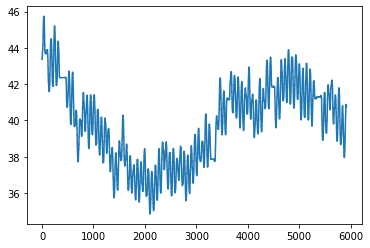

In [103]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))

def normalize(x):
    x /= np.linalg.norm(x)
    return x

def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while True:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        #print('x:', x, 'y:', y)
        #print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            #print('sol1:', sol1, 'sol2:', sol2)
            #print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    #print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    #print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx - ty > 0.000001:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if (x - sol1) < 0.000001:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        #print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            #print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = np.linalg.norm(vel_vec)*normalize(ref)
        #print('ref:', ref, 'ref shape:', ref.shape)
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        #print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)
        


#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>(h+s):
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            print('next wall: left')
        else:
            xf = l
            print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            print('bottom bar')
            tf1 = tf - s/v
            tf2 = tf + s/v
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(i, tf+(np.pi/omega),y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf2 = xf1 + u*(tf2-root)
                if abs(xf2)>l:
                    if abs(xf2%(4*l)) > l:
                        xf2 = xf2%(4*l)
                        if abs(xf2) > (3*l):
                            xf2 = (-np.sign(xf2)*4*l)- xf2
                        elif abs(xf2) > l:
                            xf2 = (np.sign(xf2)*2*l)- xf2
                    
                xf = xf2
                yf = -h
                uf = u
                if abs(xf2)>l:
                    print('out!')
                
            else:
                print('root out of bounds')
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


    


    


In [92]:

def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while k<5:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        print('x:', x, 'y:', y)
        print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            print('sol1:', sol1, 'sol2:', sol2)
            print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx != ty:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if x == sol1:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = np.linalg.norm(vel_vec)*normalize(ref)
        print('ref:', ref, 'ref shape:', ref.shape)
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
#entered enclosure: x: [-1.30463345] y: 1 u: [-0.70840413] v: [0.70580705]
semicircle_enclosure(x=-1.30463345, y=h , u=-0.70840413, v=0.70580705, t=0, lam=1, l=l, h=h, s=s, omega=omega)        

entered enclosure: x: -1.30463345 y: 1 u: -0.70840413 v: 0.70580705
x: -1.30463345 y: 1
disc: 25.12445421870378
sol1: -1.9076308139462042 sol2: 0.607789047199327
ysol1: 1.600786715634544 ysol2: -0.9054113661108811
first collision
p: -3.175221362761635
nor vec: [ 1.         -0.31493867]
ref: [[0.98501219]
 [0.17248476]] ref shape: (2, 1)
x: -1.9076308139462042 y: 1.600786715634544 vel_vec: [[0.98501219]
 [0.17248476]] m: [0.17510927]
x: -1.9076308139462042 y: 1.600786715634544
disc: [12.99497945]
sol1: [-1.90763081] sol2: [1.58997615]
ysol1: [1.60078672] ysol2: [2.21325011]
p: 1.3105097919922755
nor vec: [-1.         -0.76306183]
ref: [[-0.42642001]
 [-0.90452528]] ref shape: (2, 1)
x: [1.58997615] y: [2.21325011] vel_vec: [[-0.42642001]
 [-0.90452528]] m: [2.12120736]
x: [1.58997615] y: [2.21325011]
disc: [69.33996907]
sol1: [0.07583284] sol2: [1.58997615]
ysol1: [-0.99856183] ysol2: [2.21325011]
last collision
failed!: tx [1.34131145] ty [1.34131145]
exit enclosure: x: [1.0180141] y: 

(array([1.0180141]),
 1,
 array([-0.42642001]),
 array([-0.90452528]),
 array([5.74334285]))

In [ ]:
def trapezium_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    m = v/u
    slope = 1
    wall_y_left = h
    wall_y_right = slope*(2*l)+h
    ball_y_right = m(l-x)+y 
    ball_y_left = m(-l-x)+y 
    if ball_y_left < wall_y_left or ball_y_right < wall_y_right:
        
    
                        